# Purpose

The purpose of this notebook is to compare the RMSE score from two different hyperparameter tuning methods; RandomizedSearchCV and BayesSearchCV.<br>
The Summary section shows a summary of the results.<br>

 * BayesSearchCV is an intelligent hyperparameter tuning search that can identify regions of a search space that will return hyperparameters that produce better scores.
 * RandomizedSearchCV is a non-intelligent (it does not learn from prior hyperparams tested) hyperparameter tuning search that tries random hyperparameters based on the distributions given.
 
In the Summary section the following observations were noted:
 * RandomizedSearchCV is faster in all cases due to parallel computing.  BayesSearchCV is mostly sequential processing due to the nature of the algorithmn.
 * RandomizedSearchCV performs poorly with lower iterations (unless luck is on its side) whereas BaysSearchCV performs much better.
 * RandomizedSearchCV after a certain number of iterations does not seem to produce much imporvements whereas BayesSearchCV improves greatly which makes sense given its nature of optimizations.


Surprisingly, RandomizedSearchCV performed rather well for being an non-intelligent search method.  In most cases RandomizedSearchCV produced the best scores while taking less time to execute its task.<br>
There is a balance with hyperparameter tuning that requires the user to consider their cost budget when it comes to time and computing resources.<br>
Based off the results form this experiment, RandomizedSearchCV produces satisfactory while producing those results with quicker execution time.<br>

Some notes:  The seed was changed for each change in the number of iterations.  There was a situation where RandomizedSearchCV was producing the best score regardless of the iteration number and this was due to chance that the best hyperparameters were randomly selected early in the iterations.  A better test would remove the seed/random_state to inject pure randomness and test each iteration level several times to create a distribution of scores for each iteration level.  However, that would be rather resource intensive.  Also, this test did not set out to conduct extensive feature engineering or feature selection.  It is quite possible that impacted the results.  However, both RandomizedSearchCV and BayesSearchCV scores were generally in the same ballpark.

# Loading Libraries
some might not be used

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats

In [2]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from feature_engine import encoding as enc
from feature_engine import imputation as imp
from feature_engine import transformation as trans
from feature_engine.wrappers import SklearnTransformerWrapper

from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical
from skopt.plots import plot_objective

from xgboost import XGBRegressor

In [3]:
pd.options.display.float_format = '{:.2f}'.format
# pandas was displaying scientific notations for the 'Price' target which made it hard to read

pd.options.display.max_columns = None

In [73]:
# %load_ext watermark
%watermark -a "Brandon Johnson" -v

Author: Brandon Johnson

Python implementation: CPython
Python version       : 3.10.9
IPython version      : 8.10.0



# Loading Data and EDA

In [4]:
df1 = pd.read_csv('USA_Housing.csv')

In [5]:
df1.sample(5)

,Avg. Area Income,Avg. Area House Age,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population,Price,Address
4737,86962.96,6.52,5.33,4.17,50350.96,1798521.60,USS Taylor\nFPO AA 80749
762,65908.74,5.30,6.83,3.29,24080.59,864446.79,"907 Maria Branch\nJamesport, VT 98208-9060"
1811,59691.07,7.09,6.32,4.11,27769.50,992053.05,"13365 Huber Lane\nWoodston, AR 38916"
4337,67846.05,5.38,6.10,4.15,27442.10,879511.20,"070 Sanchez Knoll Suite 569\nSaraville, MP 39758"
316,55860.68,7.75,9.02,5.12,40335.22,1494241.23,"4458 Cabrera Plains Apt. 502\nMezamouth, MP 58250"


In [6]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Avg. Area Income              5000 non-null   float64
 1   Avg. Area House Age           5000 non-null   float64
 2   Avg. Area Number of Rooms     5000 non-null   float64
 3   Avg. Area Number of Bedrooms  5000 non-null   float64
 4   Area Population               5000 non-null   float64
 5   Price                         5000 non-null   float64
 6   Address                       5000 non-null   object 
dtypes: float64(6), object(1)
memory usage: 273.6+ KB


In [7]:
X = df1.drop(columns='Price')
y = df1['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Xy_train = pd.concat([X_train, y_train], axis=1)

In [8]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3350 entries, 1522 to 860
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Avg. Area Income              3350 non-null   float64
 1   Avg. Area House Age           3350 non-null   float64
 2   Avg. Area Number of Rooms     3350 non-null   float64
 3   Avg. Area Number of Bedrooms  3350 non-null   float64
 4   Area Population               3350 non-null   float64
 5   Address                       3350 non-null   object 
dtypes: float64(5), object(1)
memory usage: 183.2+ KB


In [9]:
Xy_train.describe()

,Avg. Area Income,Avg. Area House Age,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population,Price
count,3350.00,3350.00,3350.00,3350.00,3350.00,3350.00
mean,68596.08,5.97,6.99,3.99,36055.73,1229792.91
std,10717.60,0.99,1.01,1.23,9969.38,356372.84
min,17796.63,2.68,3.24,2.00,3285.45,15938.66
25%,61417.75,5.31,6.30,3.15,29353.70,991932.50
50%,68949.33,5.97,7.01,4.05,36245.43,1228671.52
75%,75904.63,6.67,7.67,4.50,42803.45,1474514.39
max,104702.72,9.52,10.28,6.50,69621.71,2370231.32


In [10]:
def histo(data):
    data.hist(figsize=(10,10),)
    plt.tight_layout()

# distributions look relatively gaussian for the most part

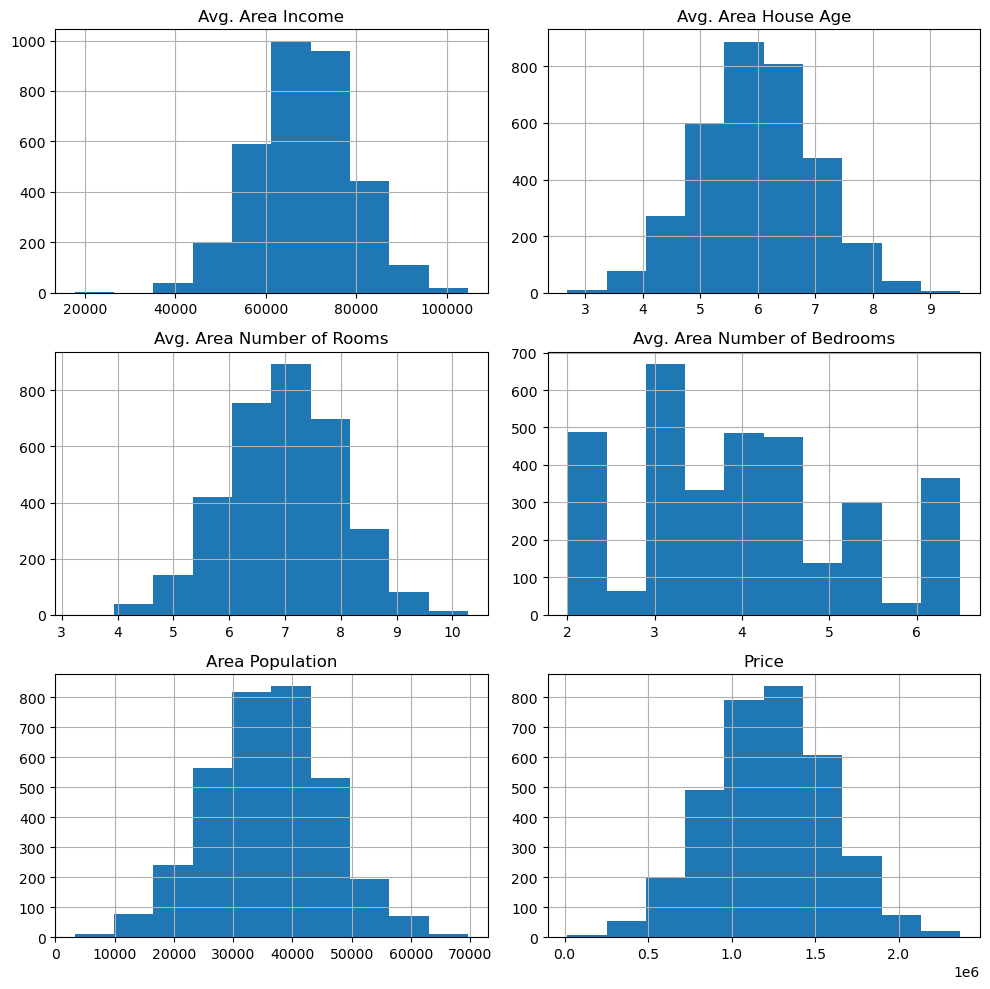

In [11]:
histo(Xy_train)

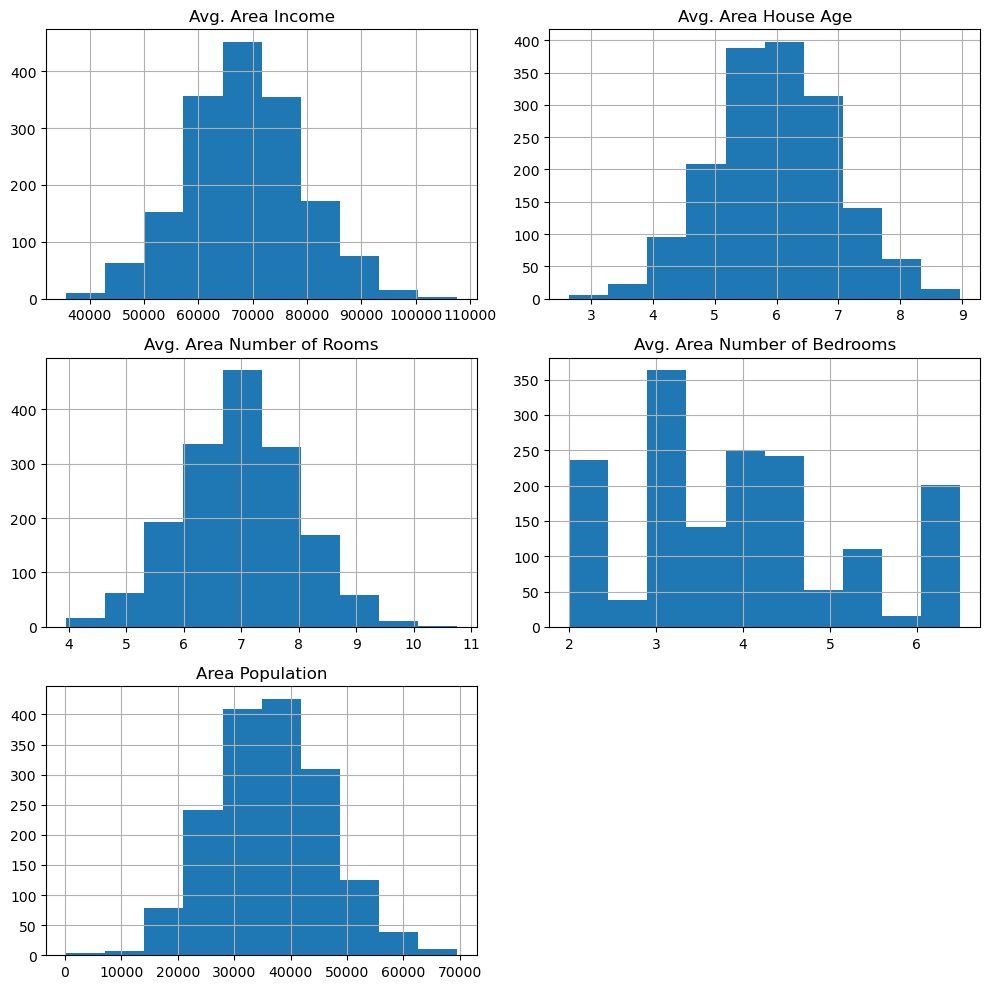

In [12]:
histo(X_test)

In [13]:
def scaled_boxplot(data):
    scaler = SklearnTransformerWrapper(StandardScaler())
    scaled_train = scaler.fit_transform(data)
    
    plt.figure(figsize=(20,8))
    sns.boxplot(scaled_train)
    plt.title('Z-scaled Data')

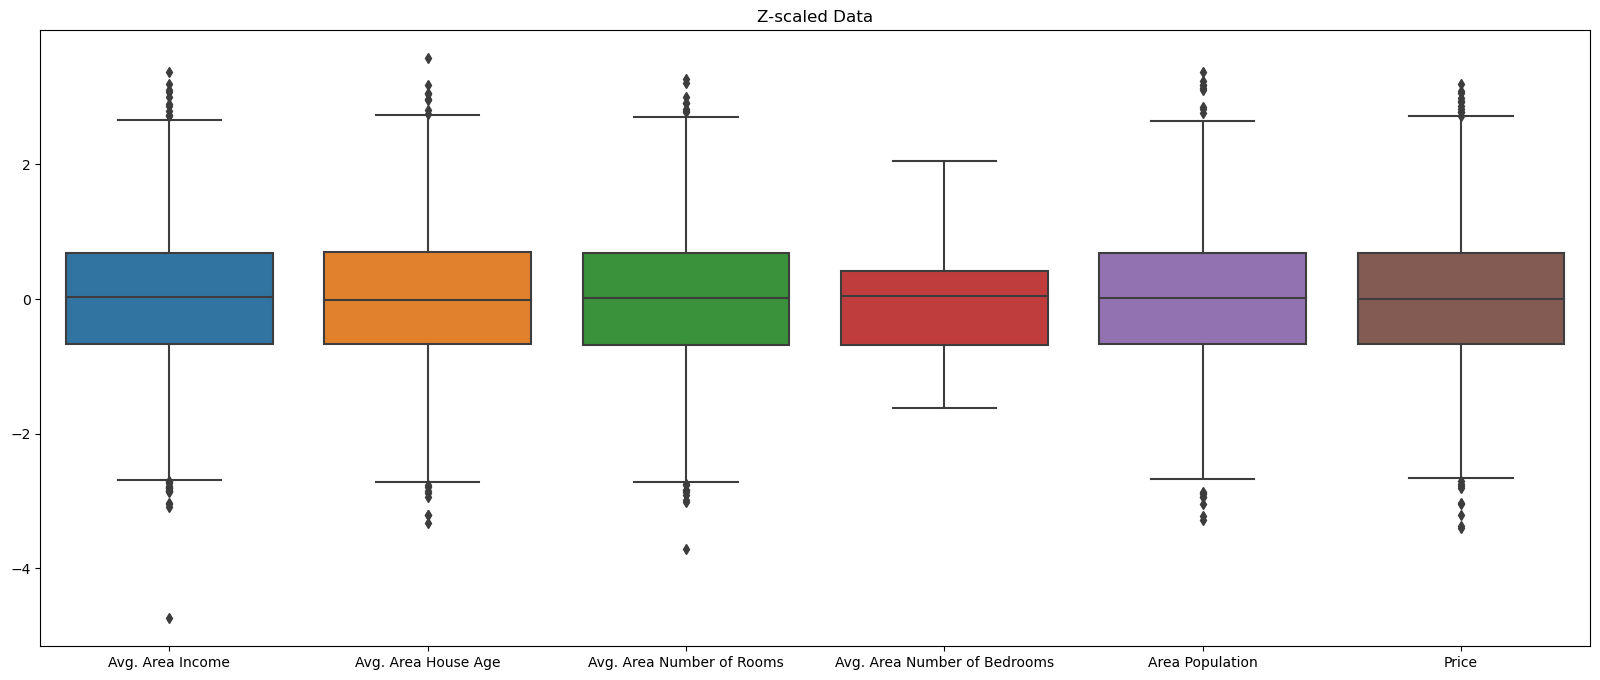

In [14]:
scaled_boxplot(Xy_train)
# scaled the data for easier multivariate analysis 
# looks like some outliers are present but, since this is a reality when it comes to features related to houses (some homes and features are expensive and cheap)
# it might not be useful to remove outliers.  

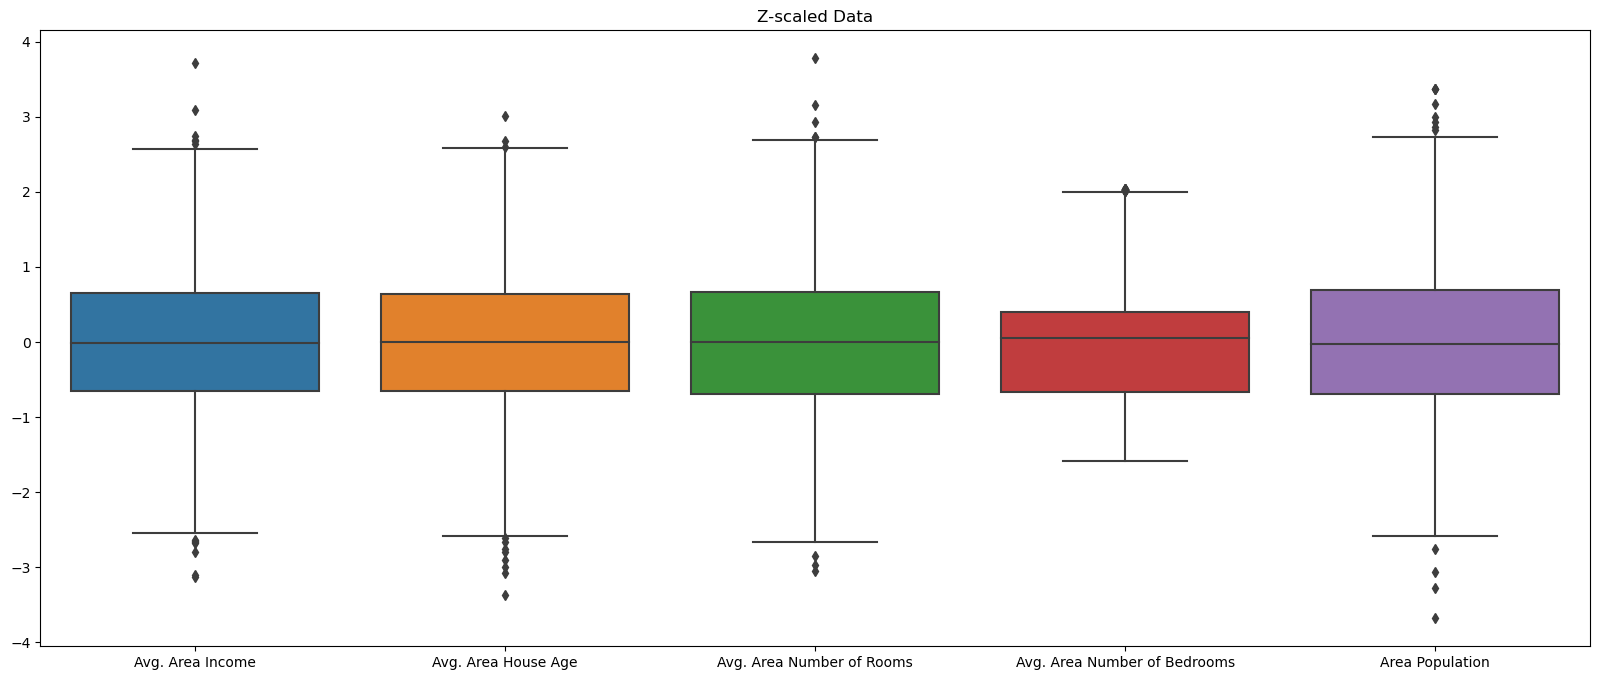

In [15]:
scaled_boxplot(X_test)

In [16]:
def corr_analysis(data):
    sns.heatmap(data.corr(numeric_only=True), annot=True, cmap='Blues')

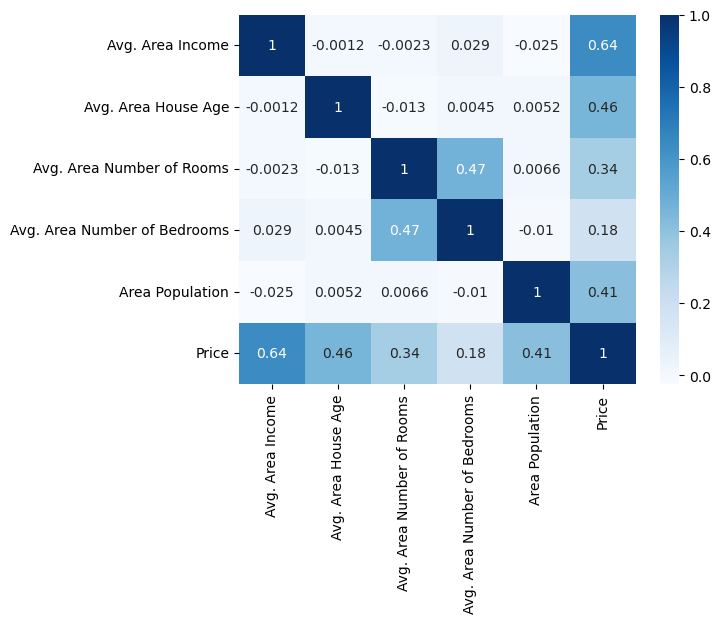

In [17]:
corr_analysis(Xy_train)

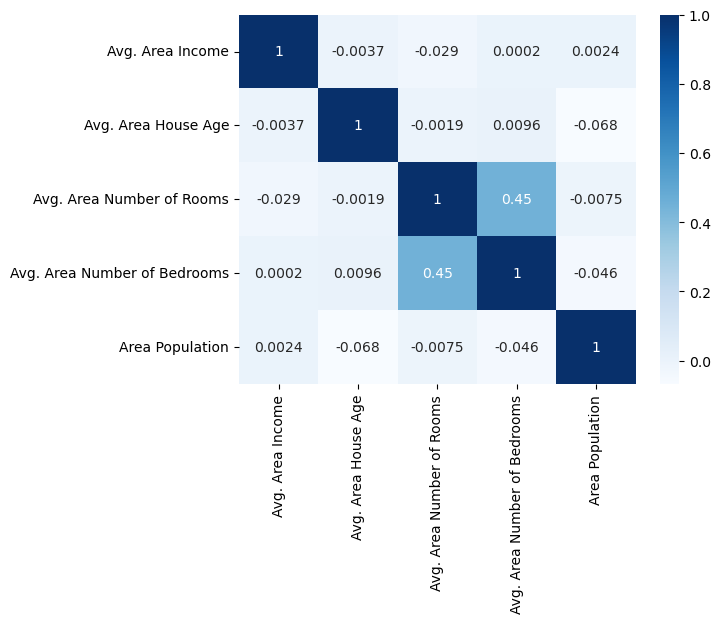

In [18]:
corr_analysis(X_test)

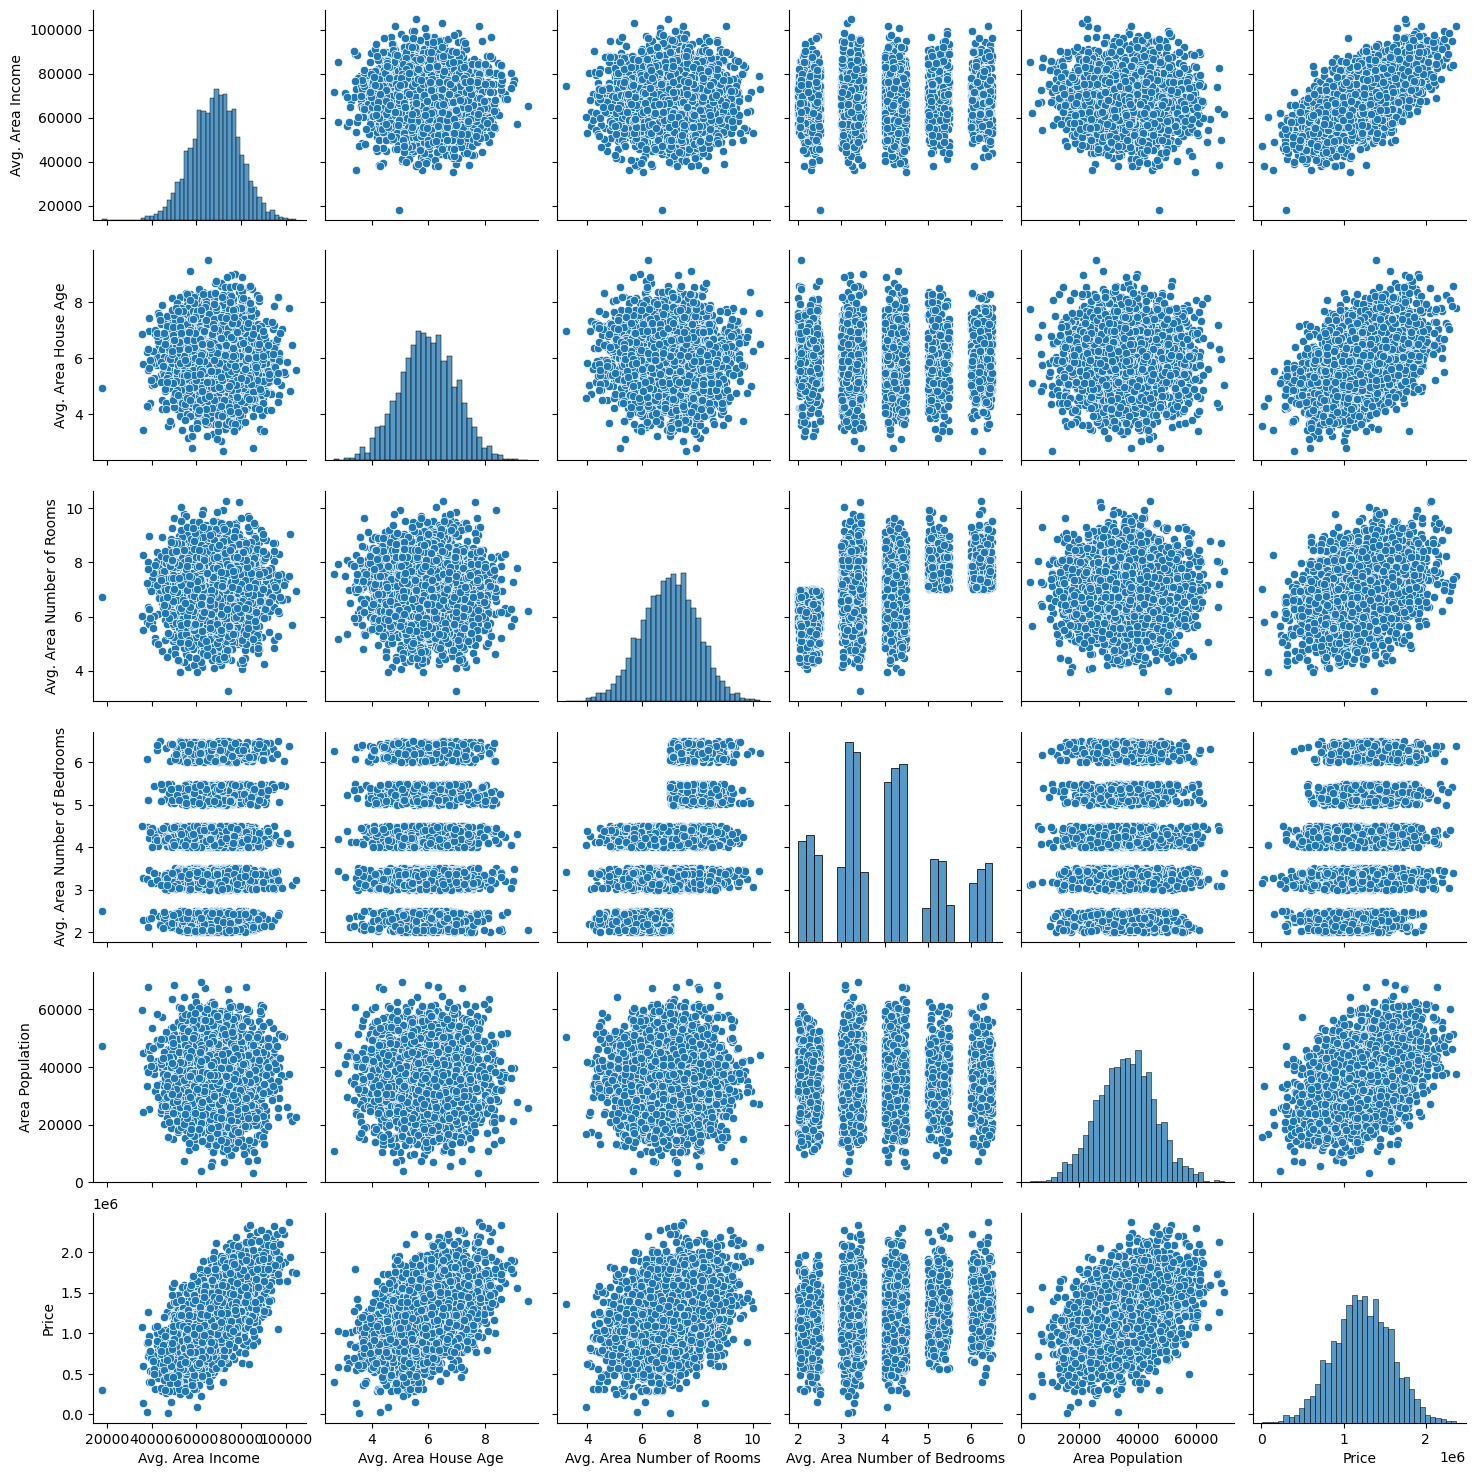

In [19]:
sns.pairplot(Xy_train)

In [20]:
def extract_numeric(X_train, X_test):
    X_train1 = X_train.select_dtypes(include= 'number')
    X_test1 = X_test.select_dtypes(include= 'number')
    return X_train1, X_test1

X_train1, X_test1 = extract_numeric(X_train, X_test)

# removing the 'Address' feature, though, extracting the state and zipcode is probably useful
# this was not a necessary function considering this feature could have been dropped when splitting the data

In [21]:
X_train1

,Avg. Area Income,Avg. Area House Age,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population
1522,67716.75,6.43,7.75,5.28,40562.19
835,78095.35,6.84,7.12,3.00,32346.43
358,55577.07,6.53,7.16,3.47,19560.01
138,63876.06,7.08,7.19,3.37,38052.88
299,52188.12,5.64,5.81,4.03,42495.75
...,...,...,...,...,...
4426,76223.56,6.37,5.34,2.42,30165.34
466,56685.01,6.96,7.50,3.38,43322.17
3092,66195.34,6.51,6.61,3.14,37288.92
3772,58694.52,7.39,9.27,4.32,49960.98


# Modeling

## Tuning Function

In [22]:
def tuning(X, y, estimator, params, scoring='neg_root_mean_squared_error', iterations=100, cv=5, bayes_search=False, seed=1):
    ''' If bayes_search=False then RandomizedSearchCV is used.  If true then BayesSearchCV is used.
    Returns: Results, Fitted Model'''
    
    if bayes_search == False:
        rand_search = RandomizedSearchCV(
            estimator= estimator, 
            param_distributions= params, 
            scoring= scoring, 
            cv= cv, 
            n_iter= iterations,
            n_jobs= -1,
            random_state=seed
        )
        
        rand_search.fit(X,y)
        print('Best Params: {}'.format(rand_search.best_params_))
        print('Best Score: {}'.format(rand_search.best_score_))
        print('')
        results = pd.DataFrame(rand_search.cv_results_)
        display(results[['mean_test_score','std_test_score']].sort_values(by='mean_test_score', ascending=False).reset_index(drop=True).head(10))
        print('')
        plt.figure(figsize=(10,5))
        results['mean_test_score'].plot(yerr=[results['std_test_score'], results['std_test_score']], subplots=True)
        plt.ylabel('Neg RMSE')
        plt.xlabel('Iterations')
        
        return results, rand_search
    
    
    if bayes_search == True:
        bay_search = BayesSearchCV(estimator=estimator, 
                                   scoring=scoring, 
                                   search_spaces=params, 
                                   n_iter=iterations, 
                                   cv=cv,
                                   n_jobs=-1,
                                   random_state=seed,
                                  optimizer_kwargs = {
                                      'base_estimator':'GBRT',
                                      'n_jobs':-1,
                                      'acq_func':'EI'
                                  })
        bay_search.fit(X,y)
        print('Best Params: {}'.format(bay_search.best_params_))
        print('Best Score: {}'.format(bay_search.best_score_))
        print('')
        results = pd.DataFrame(bay_search.cv_results_)
        display(results[['mean_test_score','std_test_score']].sort_values(by='mean_test_score', ascending=False).reset_index(drop=True).head(10))
        print('')
        plt.figure(figsize=(10,5))
        results['mean_test_score'].plot(yerr=[results['std_test_score'], results['std_test_score']], subplots=True)
        plt.ylabel('Neg RMSE')
        plt.xlabel('Iterations')
        plot_objective(bay_search.optimizer_results_[0])
        
        return results, bay_search

## RandomizedSearchCV Tuning

### Trial 1 10 iterations

Best Params: {'gamma': 9.670301687152865, 'learning_rate': 0.2736614013629436, 'max_depth': 2, 'n_estimators': 410, 'subsample': 0.8574079968371824}
Best Score: -114173.019554926



,mean_test_score,std_test_score
0,-114173.02,2942.25
1,-114543.28,2407.44
2,-115105.47,2751.31
3,-119981.36,2619.85
4,-120806.67,3091.67
5,-125373.27,954.67
6,-130482.10,2600.92
7,-131793.19,3022.67
8,-138755.28,3169.90
9,-146832.69,3509.30



CPU times: total: 5.25 s
Wall time: 15.7 s


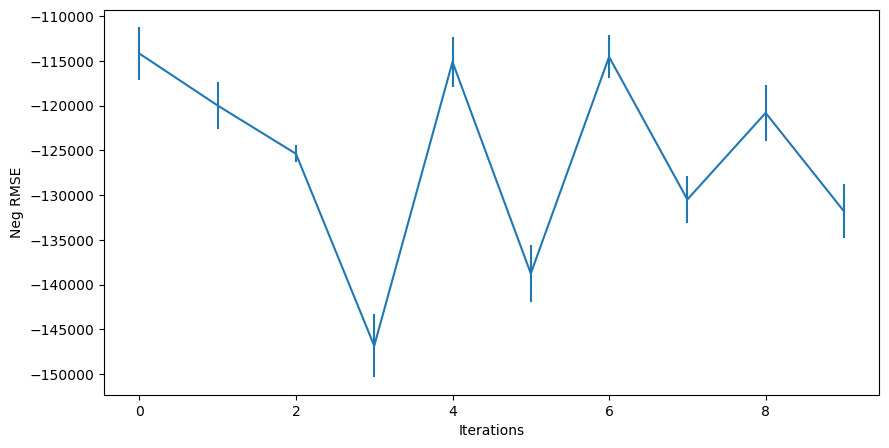

In [23]:
%%time

xgbr = XGBRegressor(n_jobs=-1)

params = {
    'n_estimators': stats.randint(50,1500),
    'max_depth': stats.randint(1,10),
    'learning_rate': stats.uniform(0.0001, (0.5-0.0001)),
    'gamma': stats.uniform(0.0001, (10-0.0001)),
    'subsample': stats.uniform(0.5, (1-0.5))
}

rand_results1, rand_model1 = tuning(X=X_train1, y=y_train, estimator=xgbr, params=params, iterations=10, seed=4)

### Trial 2 25 iterations

Best Params: {'gamma': 2.6924288589527876, 'learning_rate': 0.14596720783529374, 'max_depth': 1, 'n_estimators': 561, 'subsample': 0.9302669564734632}
Best Score: -107004.14310821479



,mean_test_score,std_test_score
0,-107004.14,2811.50
1,-107892.10,2403.44
2,-108809.22,2814.50
3,-109338.72,2751.71
4,-110932.80,2241.93
5,-112909.06,3310.62
6,-114057.07,3200.93
7,-115606.26,1778.89
8,-118378.35,2161.48
9,-120786.69,1821.08



CPU times: total: 5.17 s
Wall time: 18 s


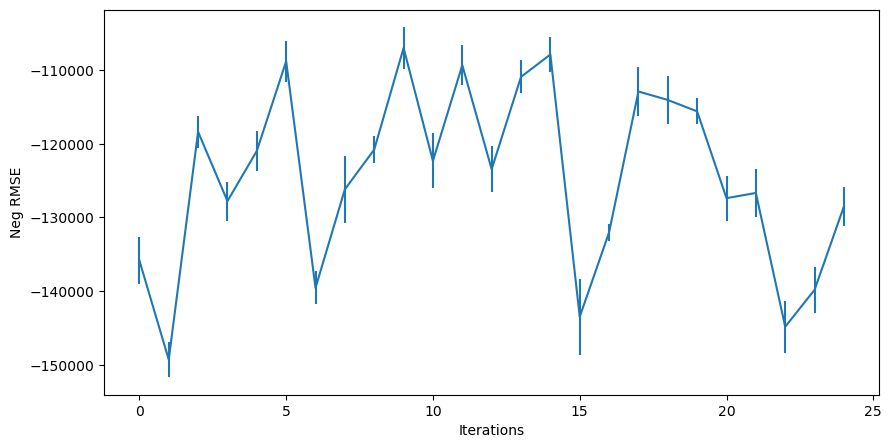

In [24]:
%%time

xgbr = XGBRegressor(n_jobs=-1)

params = {
    'n_estimators': stats.randint(50,1500),
    'max_depth': stats.randint(1,10),
    'learning_rate': stats.uniform(0.0001, (0.5-0.0001)),
    'gamma': stats.uniform(0.0001, (10-0.0001)),
    'subsample': stats.uniform(0.5, (1-0.5))
}

rand_results2, rand_model2 = tuning(X=X_train1, y=y_train, estimator=xgbr, params=params, iterations=25, seed=3)

### Trial 3 50 iterations

Best Params: {'gamma': 4.26028265830812, 'learning_rate': 0.161504819294635, 'max_depth': 1, 'n_estimators': 474, 'subsample': 0.8556086213937213}
Best Score: -107365.15951693481



,mean_test_score,std_test_score
0,-107365.16,2756.17
1,-108619.57,2674.58
2,-109008.41,3125.91
3,-109503.45,3190.74
4,-109930.78,2206.27
5,-111334.04,3451.90
6,-112093.05,2645.35
7,-113656.04,3574.62
8,-113969.61,3097.23
9,-114455.06,4086.70



CPU times: total: 4.95 s
Wall time: 39 s


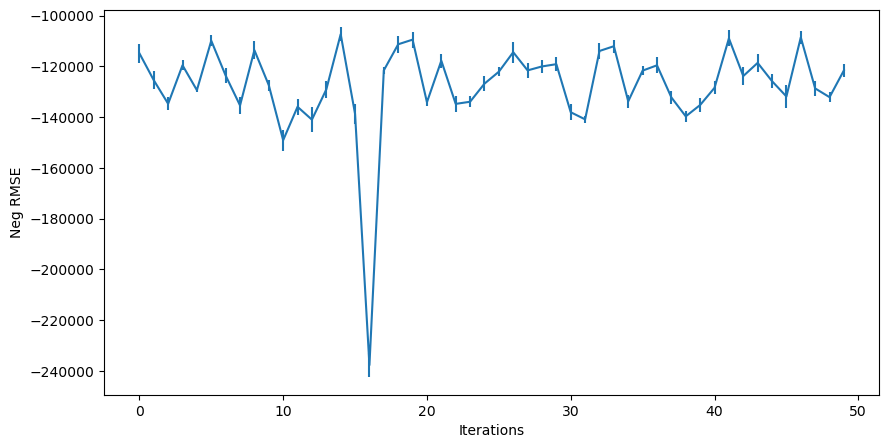

In [25]:
%%time

xgbr = XGBRegressor(n_jobs=-1)

params = {
    'n_estimators': stats.randint(50,1500),
    'max_depth': stats.randint(1,10),
    'learning_rate': stats.uniform(0.0001, (0.5-0.0001)),
    'gamma': stats.uniform(0.0001, (10-0.0001)),
    'subsample': stats.uniform(0.5, (1-0.5))
}

rand_results3, rand_model3 = tuning(X=X_train1, y=y_train, estimator=xgbr, params=params, iterations=50, seed=2)

### Trial 4 100 iterations

Best Params: {'gamma': 5.586942415474672, 'learning_rate': 0.07027943060375737, 'max_depth': 1, 'n_estimators': 1160, 'subsample': 0.9003722843377684}
Best Score: -106432.79291885952



,mean_test_score,std_test_score
0,-106432.79,3101.27
1,-106979.20,2919.29
2,-107395.39,2875.92
3,-107731.13,2626.21
4,-107940.28,3012.83
5,-108496.26,1951.37
6,-108598.04,2826.78
7,-108609.93,2836.76
8,-109239.61,2743.53
9,-109390.82,3330.57



CPU times: total: 12.8 s
Wall time: 1min 13s


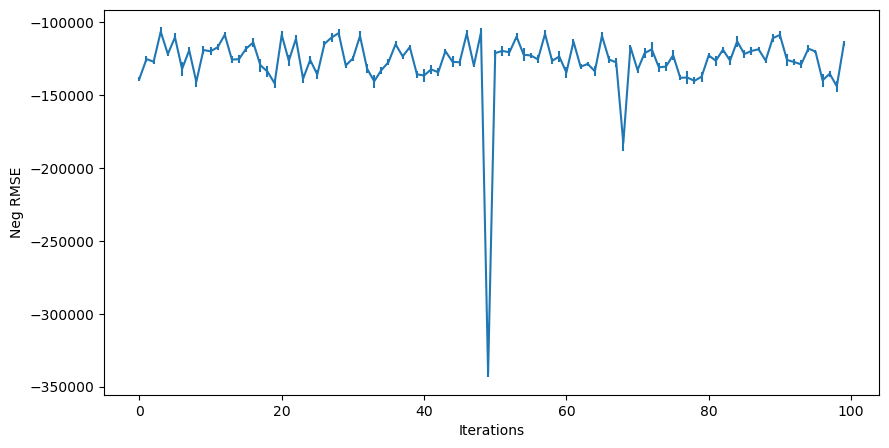

In [26]:
%%time

xgbr = XGBRegressor(n_jobs=-1)

params = {
    'n_estimators': stats.randint(50,1500),
    'max_depth': stats.randint(1,10),
    'learning_rate': stats.uniform(0.0001, (0.5-0.0001)),
    'gamma': stats.uniform(0.0001, (10-0.0001)),
    'subsample': stats.uniform(0.5, (1-0.5))
}

rand_results4, rand_model4 = tuning(X=X_train1, y=y_train, estimator=xgbr, params=params)

### Trial 5 200 iterations

Best Params: {'gamma': 1.330047931047421, 'learning_rate': 0.10855031073264322, 'max_depth': 1, 'n_estimators': 605, 'subsample': 0.714680505817949}
Best Score: -106715.29231750961



,mean_test_score,std_test_score
0,-106715.29,2430.62
1,-106839.62,2814.20
2,-106882.77,2478.01
3,-106885.66,3081.14
4,-107075.01,2773.58
5,-107760.89,3099.96
6,-107838.96,2986.05
7,-108116.97,2453.14
8,-108268.35,2329.40
9,-108329.32,2852.33



CPU times: total: 8.8 s
Wall time: 2min 20s


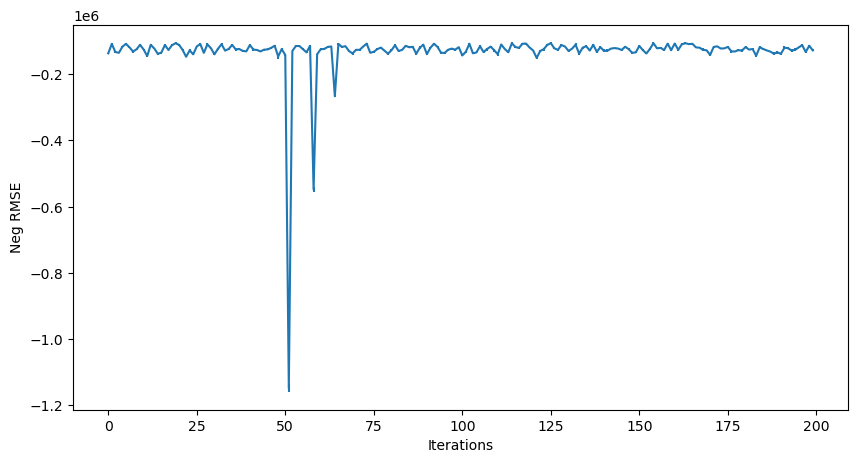

In [27]:
%%time

xgbr = XGBRegressor(n_jobs=-1)

params = {
    'n_estimators': stats.randint(50,1500),
    'max_depth': stats.randint(1,10),
    'learning_rate': stats.uniform(0.0001, (0.5-0.0001)),
    'gamma': stats.uniform(0.0001, (10-0.0001)),
    'subsample': stats.uniform(0.5, (1-0.5))
}

rand_results5, rand_model5 = tuning(X=X_train1, y=y_train, estimator=xgbr, params=params, iterations=200, seed=5)

## BayesSearchCV Tuning

### Trial 1 10 iterations

Best Params: OrderedDict([('gamma', 1.2683317967324015), ('learning_rate', 0.45722274221224624), ('max_depth', 1), ('n_estimators', 535), ('subsample', 0.9588428380809493)])
Best Score: -109614.08622297121



,mean_test_score,std_test_score
0,-109614.09,2507.37
1,-121194.79,2714.02
2,-121797.01,2878.69
3,-123333.96,3002.79
4,-124258.85,2307.04
5,-127007.57,1858.19
6,-130706.67,3611.38
7,-133546.08,3626.69
8,-140569.18,2278.69
9,-358214.16,2478.58



CPU times: total: 11.7 s
Wall time: 27.9 s


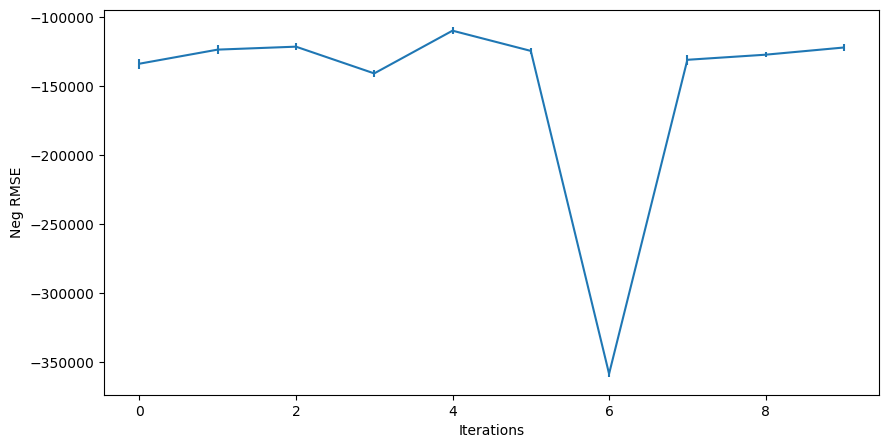

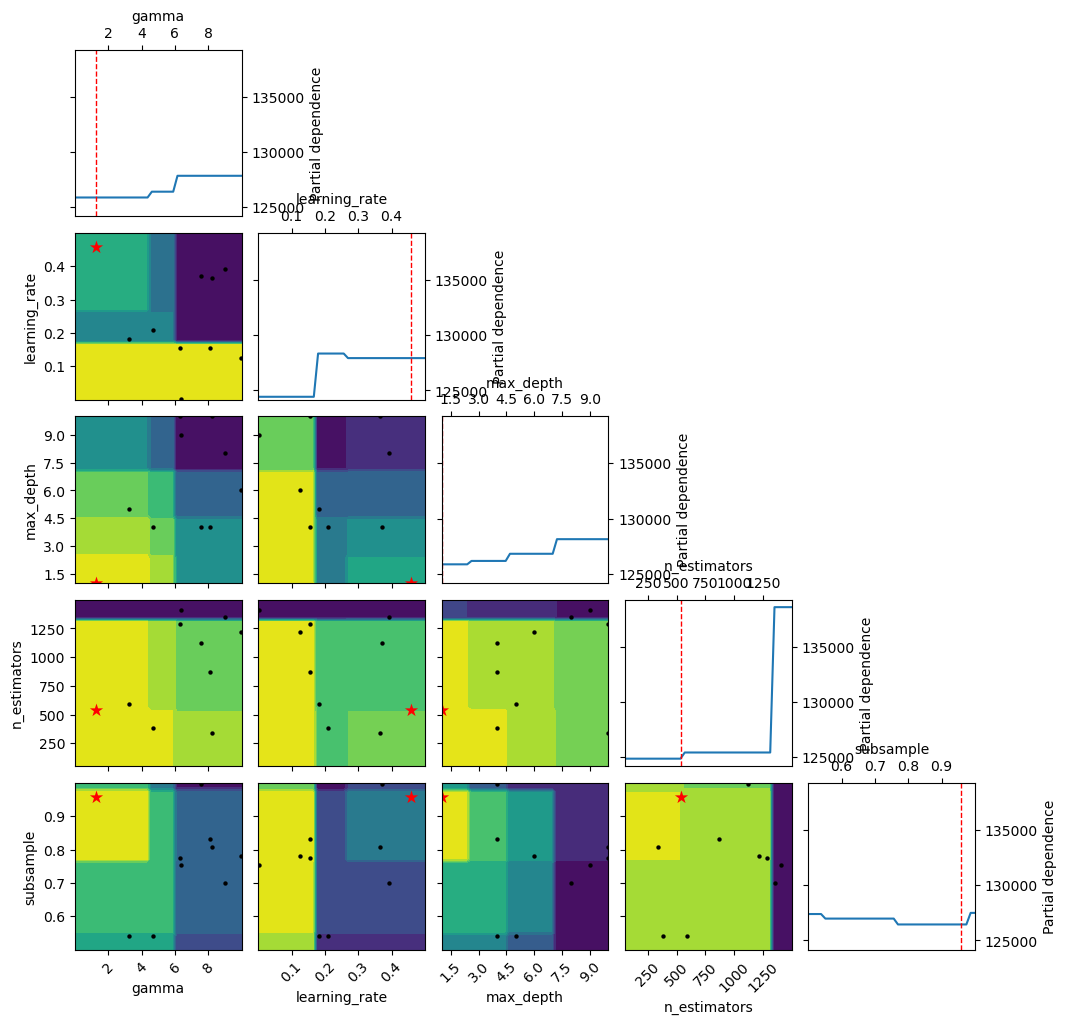

In [31]:
%%time

xgbr = XGBRegressor(n_jobs=-1)

params = {
    'n_estimators': Integer(50, 1500),
    'max_depth': Integer(1, 10),
    'learning_rate': Real(0.0001, 0.5),
    'gamma': Real(0.0001, 10),
    'subsample': Real(0.5, 1)
}

bay_results1, bay_model1 = tuning(X=X_train1, y=y_train, estimator=xgbr, params=params, bayes_search=True, iterations=10, seed=4)

### Trial 2 25 iterations

Best Params: OrderedDict([('gamma', 0.19341161440428312), ('learning_rate', 0.2354666957495542), ('max_depth', 1), ('n_estimators', 380), ('subsample', 0.607453566483522)])
Best Score: -107945.82716967615



,mean_test_score,std_test_score
0,-107945.83,3023.32
1,-109113.63,3287.88
2,-109593.33,2558.54
3,-109611.83,2807.78
4,-110266.95,2917.12
5,-111588.52,2222.31
6,-112834.93,2823.66
7,-114580.78,3732.32
8,-114657.87,1984.47
9,-115188.18,3978.71



CPU times: total: 12.4 s
Wall time: 27.6 s


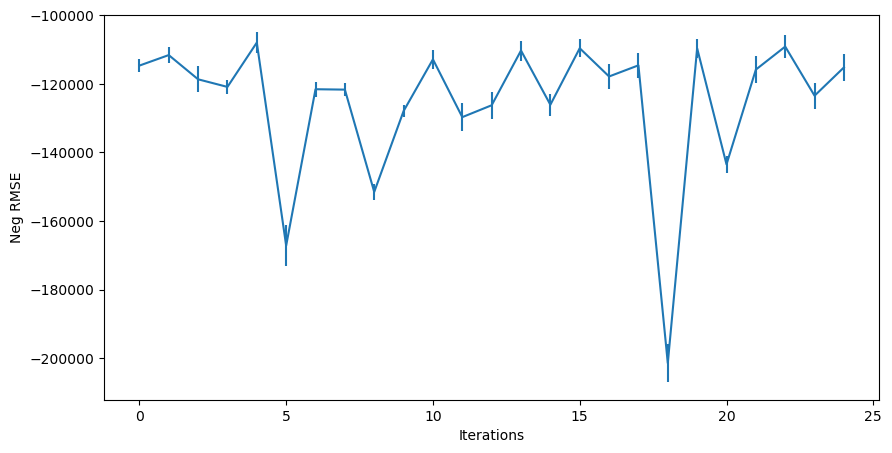

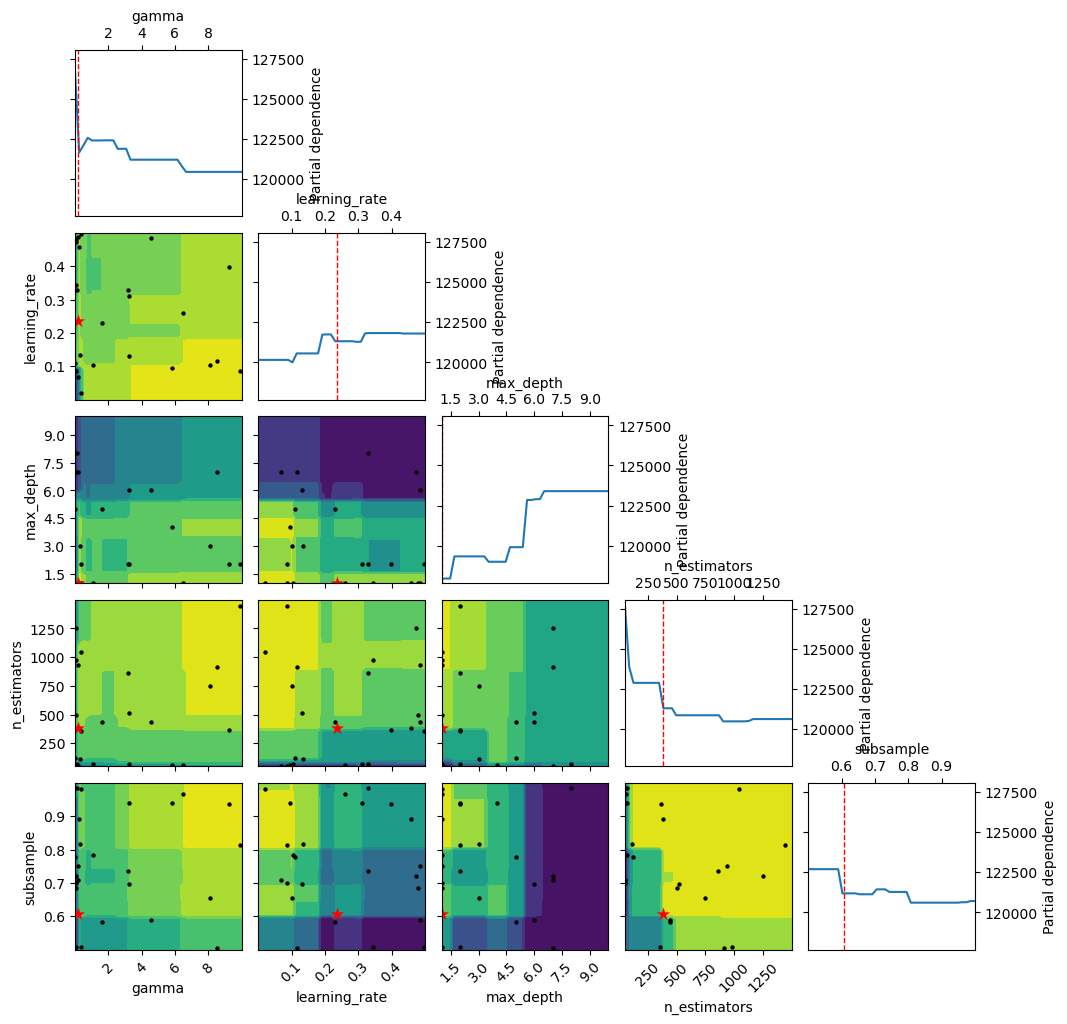

In [32]:
%%time

xgbr = XGBRegressor(n_jobs=-1)

params = {
    'n_estimators': Integer(50, 1500),
    'max_depth': Integer(1, 10),
    'learning_rate': Real(0.0001, 0.5),
    'gamma': Real(0.0001, 10),
    'subsample': Real(0.5, 1)
}

bay_results2, bay_model2 = tuning(X=X_train1, y=y_train, estimator=xgbr, params=params, bayes_search=True, iterations=25, seed=3)

### Trial 3 50 iterations

Best Params: OrderedDict([('gamma', 1.7380813765604641), ('learning_rate', 0.03472632193324066), ('max_depth', 1), ('n_estimators', 1455), ('subsample', 0.5307095155525959)])
Best Score: -105786.55789359767



,mean_test_score,std_test_score
0,-105786.56,2839.17
1,-107827.53,2775.56
2,-108534.74,2634.34
3,-109023.10,3052.51
4,-109075.37,3815.05
5,-109090.94,2377.65
6,-110104.45,3345.76
7,-110149.97,3303.58
8,-111557.46,3559.95
9,-111951.38,2200.56



CPU times: total: 24.2 s
Wall time: 1min 4s


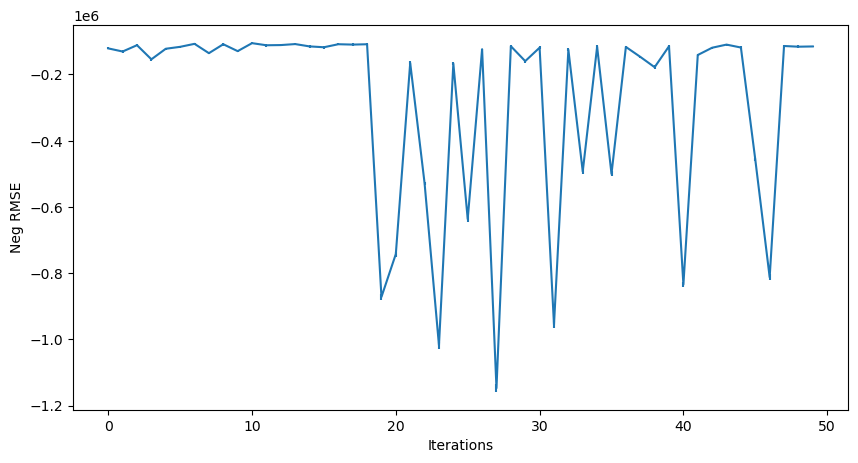

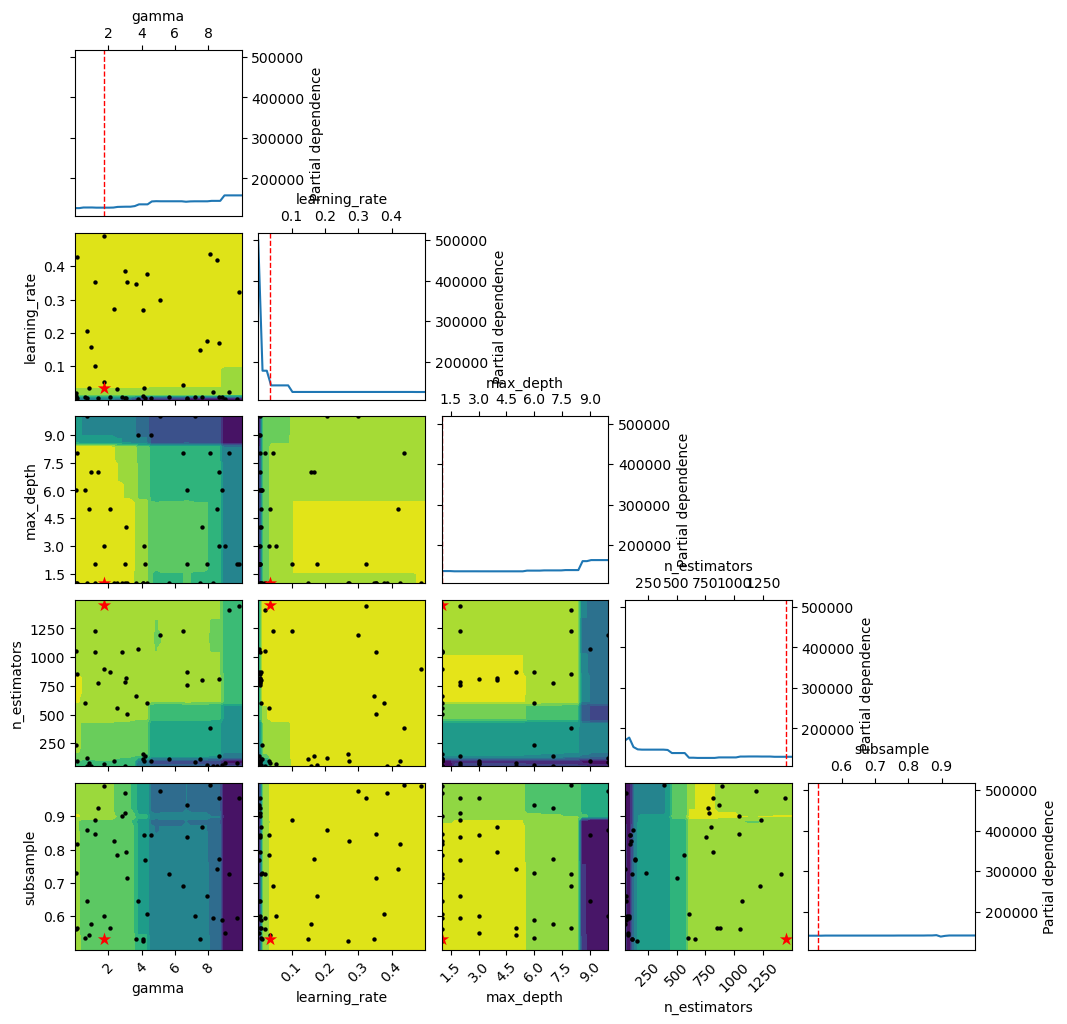

In [33]:
%%time

xgbr = XGBRegressor(n_jobs=-1)

params = {
    'n_estimators': Integer(50, 1500),
    'max_depth': Integer(1, 10),
    'learning_rate': Real(0.0001, 0.5),
    'gamma': Real(0.0001, 10),
    'subsample': Real(0.5, 1)
}

bay_results3, bay_model3 = tuning(X=X_train1, y=y_train, estimator=xgbr, params=params, bayes_search=True, iterations=50, seed=2)

### Trail 4 100 iterations

Best Params: OrderedDict([('gamma', 6.128649709664192), ('learning_rate', 0.01099286208264564), ('max_depth', 2), ('n_estimators', 1481), ('subsample', 0.6434711027414717)])
Best Score: -107942.57346118528



,mean_test_score,std_test_score
0,-107942.57,2761.10
1,-108490.00,3100.88
2,-108498.08,2900.15
3,-108526.42,3008.96
4,-108880.19,3062.51
5,-108898.80,3096.94
6,-109061.68,2643.72
7,-109142.84,2900.50
8,-109333.54,3008.21
9,-109425.23,3079.29



CPU times: total: 35.1 s
Wall time: 2min 29s


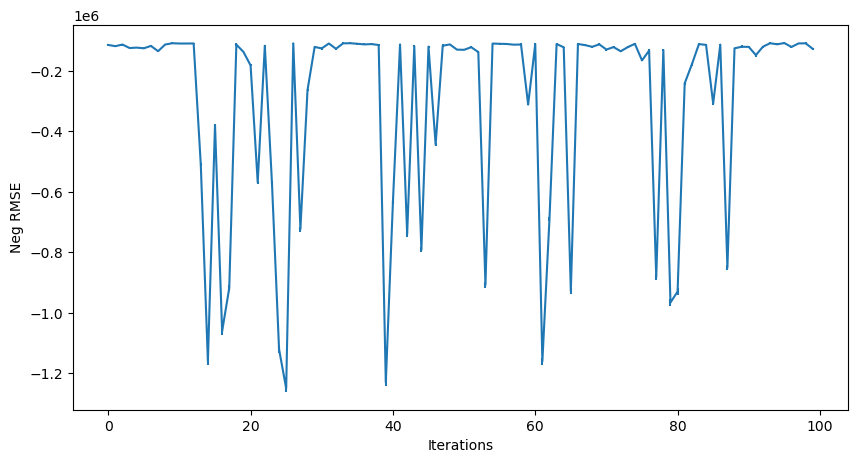

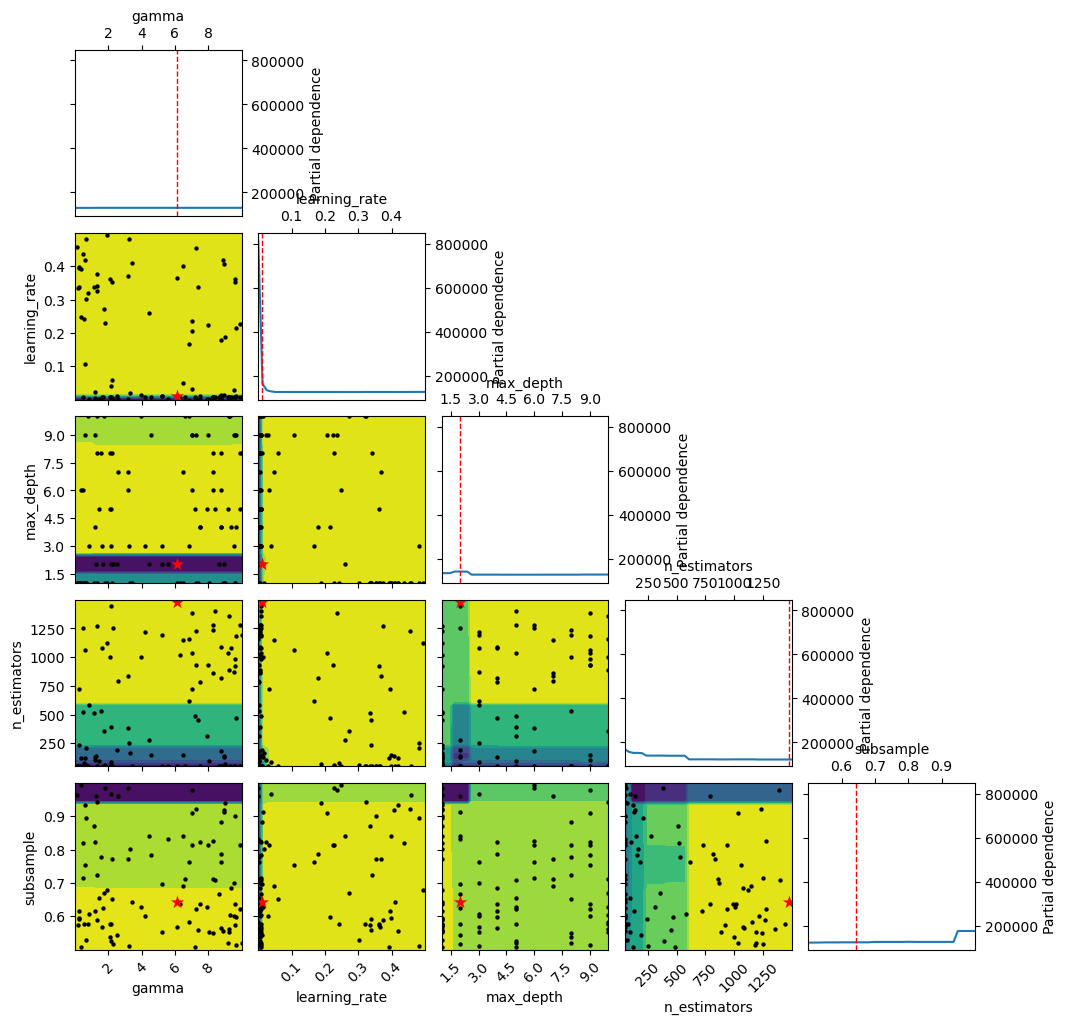

In [34]:
%%time

xgbr = XGBRegressor(n_jobs=-1)

params = {
    'n_estimators': Integer(50, 1500),
    'max_depth': Integer(1, 10),
    'learning_rate': Real(0.0001, 0.5),
    'gamma': Real(0.0001, 10),
    'subsample': Real(0.5, 1)
}

bay_results4, bay_model4 = tuning(X=X_train1, y=y_train, estimator=xgbr, params=params, bayes_search=True)

### Trial 5 200 iterations

Best Params: OrderedDict([('gamma', 7.152457015051894), ('learning_rate', 0.055203342447394464), ('max_depth', 1), ('n_estimators', 515), ('subsample', 0.5163165251442865)])
Best Score: -107137.68901294125



,mean_test_score,std_test_score
0,-107137.69,2651.95
1,-107170.75,2697.13
2,-107602.51,2382.63
3,-107702.65,2905.95
4,-108095.52,2747.33
5,-108109.98,3495.92
6,-108117.92,2880.81
7,-108237.43,2935.40
8,-108304.74,3002.09
9,-108479.80,3202.19



CPU times: total: 35.1 s
Wall time: 5min 12s


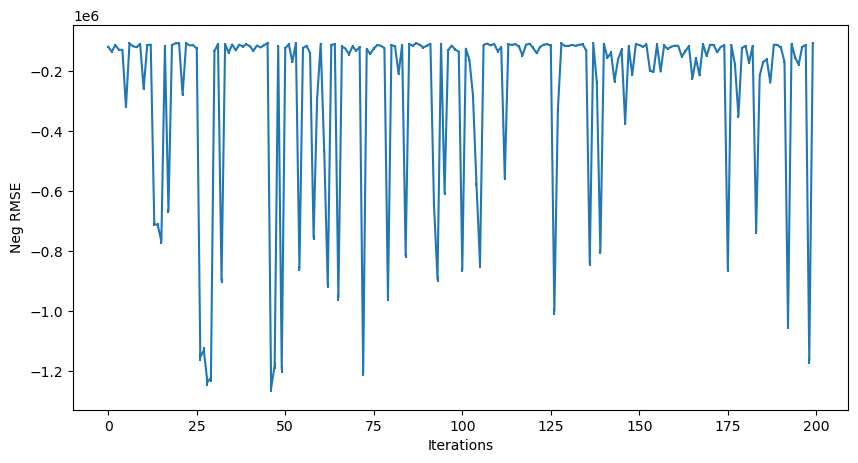

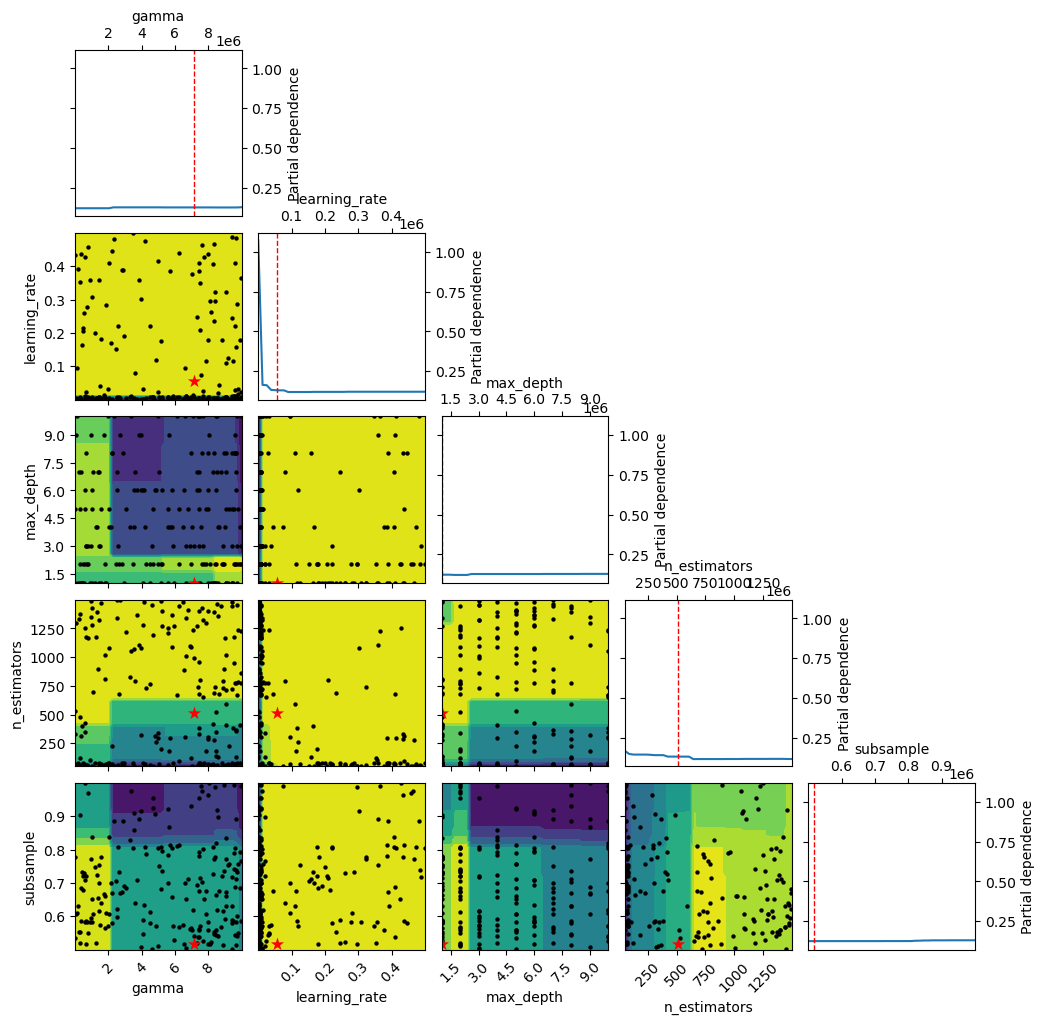

In [35]:
%%time

xgbr = XGBRegressor(n_jobs=-1)

params = {
    'n_estimators': Integer(50, 1500),
    'max_depth': Integer(1, 10),
    'learning_rate': Real(0.0001, 0.5),
    'gamma': Real(0.0001, 10),
    'subsample': Real(0.5, 1)
}

bay_results5, bay_model5 = tuning(X=X_train1, y=y_train, estimator=xgbr, params=params, bayes_search=True, iterations=200, seed=5)

# Compairing Results

In [37]:
xgb_cols= ['param_gamma', 'param_learning_rate', 'param_max_depth', 'param_n_estimators', 'param_subsample', 'mean_test_score', 'std_test_score']

In [38]:
def scorer(estimator=None, X_test_data=None, y_test_data=None):
    y_pred = estimator.predict(X_test_data)
    score = np.sqrt(mean_squared_error(y_test_data, y_pred))
    print('RMSE : %.3f' % score)

## Trial 1 10 iterations

In [39]:
rand_results1[xgb_cols].head()

,param_gamma,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,mean_test_score,std_test_score
0,9.67,0.27,2,410,0.86,-114173.02,2942.25
1,6.98,0.11,8,159,0.50,-119981.36,2619.85
2,2.53,0.22,3,1118,0.60,-125373.27,954.67
3,8.63,0.49,8,583,0.80,-146832.69,3509.30
4,0.09,0.19,3,224,0.98,-115105.47,2751.31


In [40]:
scorer(rand_model1,X_test_data=X_test1, y_test_data=y_test)

RMSE : 110319.373


In [41]:
bay_results1[xgb_cols].head()

,param_gamma,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,mean_test_score,std_test_score
0,8.21,0.36,10,342,0.81,-133546.08,3626.69
1,6.28,0.16,10,1287,0.78,-123333.96,3002.79
2,8.10,0.15,4,867,0.83,-121194.79,2714.02
3,9.03,0.39,8,1352,0.70,-140569.18,2278.69
4,1.27,0.46,1,535,0.96,-109614.09,2507.37


In [42]:
scorer(bay_model1,X_test_data=X_test1, y_test_data=y_test)

RMSE : 105981.305


## Trial 2 25 iterations

In [43]:
rand_results2[xgb_cols].head()

,param_gamma,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,mean_test_score,std_test_score
0,5.51,0.35,9,1018,0.76,-135836.53,3175.04
1,8.93,0.45,6,1193,0.55,-149282.39,2389.07
2,6.95,0.07,9,387,0.68,-118378.35,2161.48
3,4.93,0.46,2,908,0.63,-127781.06,2654.60
4,4.15,0.14,9,557,0.72,-120977.42,2740.46


In [44]:
scorer(rand_model2,X_test_data=X_test1, y_test_data=y_test)

RMSE : 103735.747


In [45]:
bay_results2[xgb_cols].head()

,param_gamma,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,mean_test_score,std_test_score
0,8.10,0.10,3,744,0.66,-114657.87,1984.47
1,9.93,0.09,2,1441,0.81,-111588.52,2222.31
2,9.22,0.40,2,368,0.94,-118652.60,3761.89
3,3.18,0.33,2,861,0.74,-120874.31,2014.71
4,0.19,0.24,1,380,0.61,-107945.83,3023.32


In [46]:
scorer(bay_model2,X_test_data=X_test1, y_test_data=y_test)

RMSE : 104570.712


## Trials 3 50 iterations

In [47]:
rand_results3[xgb_cols].head()

,param_gamma,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,mean_test_score,std_test_score
0,4.36,0.01,7,349,0.72,-114866.73,3812.57
1,4.20,0.17,6,1121,0.65,-125482.47,3534.06
2,2.67,0.31,6,729,0.57,-134770.75,2619.93
3,5.14,0.09,8,942,0.92,-119604.72,2041.03
4,0.80,0.25,7,1425,0.71,-129412.71,609.60


In [48]:
scorer(rand_model3,X_test_data=X_test1, y_test_data=y_test)

RMSE : 103364.044


In [49]:
bay_results3[xgb_cols].head()

,param_gamma,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,mean_test_score,std_test_score
0,8.66,0.17,7,140,0.77,-121599.90,3247.41
1,8.53,0.42,5,50,0.74,-130995.27,3089.63
2,1.20,0.10,2,1230,0.89,-111951.38,2200.56
3,4.17,0.03,3,98,0.84,-154549.80,4278.62
4,0.72,0.21,10,120,0.86,-122686.06,2242.86


In [50]:
scorer(bay_model3,X_test_data=X_test1, y_test_data=y_test)

RMSE : 102654.457


## Trials 4 100 iterations

In [51]:
rand_results4[xgb_cols].head()

,param_gamma,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,mean_test_score,std_test_score
0,4.17,0.36,6,897,0.62,-138734.08,1340.68
1,3.97,0.19,7,1355,0.77,-125182.91,1977.43
2,4.19,0.34,3,630,0.71,-127020.77,1437.79
3,5.59,0.07,1,1160,0.90,-106432.79,3101.27
4,9.68,0.16,7,1387,0.94,-121744.24,1500.67


In [52]:
scorer(rand_model4,X_test_data=X_test1, y_test_data=y_test)

RMSE : 102849.260


In [53]:
bay_results4[xgb_cols].head()

,param_gamma,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,mean_test_score,std_test_score
0,7.03,0.03,6,726,0.81,-114222.93,2894.12
1,6.84,0.17,3,620,0.76,-118212.74,1303.38
2,8.30,0.01,7,864,0.71,-112854.66,3380.56
3,7.03,0.21,9,1036,0.91,-124387.66,3594.54
4,8.78,0.18,4,814,0.79,-123000.19,1626.87


In [54]:
scorer(bay_model4,X_test_data=X_test1, y_test_data=y_test)

RMSE : 103844.847


## Trial 5 200 iterations

In [55]:
rand_results5[xgb_cols].head()

,param_gamma,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,mean_test_score,std_test_score
0,2.22,0.44,7,1192,0.96,-137374.45,2092.68
1,4.88,0.31,1,720,0.74,-108881.88,3140.83
2,9.91,0.40,8,1154,0.91,-133212.62,2741.55
3,2.43,0.38,5,1160,0.71,-135803.27,1892.36
4,2.96,0.31,2,260,0.51,-117361.71,2275.71


In [56]:
scorer(rand_model5,X_test_data=X_test1, y_test_data=y_test)

RMSE : 103529.279


In [57]:
bay_results5[xgb_cols].head()

,param_gamma,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,mean_test_score,std_test_score
0,3.58,0.08,7,792,0.64,-119739.50,2847.65
1,8.01,0.44,8,286,0.96,-136177.47,2794.57
2,0.88,0.36,1,107,0.58,-113852.27,2366.80
3,3.99,0.30,6,1076,0.92,-129317.63,3076.31
4,3.85,0.36,9,1107,0.89,-129991.50,2886.42


In [58]:
scorer(bay_model5,X_test_data=X_test1, y_test_data=y_test)

RMSE : 104025.966


# Summary

In [61]:
d = {
    'trial':[1,1,2,2,3,3,4,4,5,5],
    'search_method':['rand','bay','rand','bay','rand','bay','rand','bay','rand','bay'],
    'iterations':[10,10,25,25,50,50,100,100,200,200],
    'time_sec':[15.7,27.9,18,27.6,39,64,73,149,140,312],
    'test_score_neg_RMSE':[rand_results1['mean_test_score'].iloc[0].round(2),bay_results1['mean_test_score'].iloc[0].round(2),
                           rand_results2['mean_test_score'].iloc[0].round(2),bay_results2['mean_test_score'].iloc[0].round(2),
                           rand_results3['mean_test_score'].iloc[0].round(2),bay_results3['mean_test_score'].iloc[0].round(2),
                           rand_results4['mean_test_score'].iloc[0].round(2),bay_results4['mean_test_score'].iloc[0].round(2),
                           rand_results5['mean_test_score'].iloc[0].round(2),bay_results5['mean_test_score'].iloc[0].round(2),]
}

In [62]:
trial_results = pd.DataFrame(d)
trial_results.sort_values(by=['iterations', 'search_method'])

,trial,search_method,iterations,time_sec,test_score_neg_RMSE
1,1,bay,10,27.90,-133546.08
0,1,rand,10,15.70,-114173.02
3,2,bay,25,27.60,-114657.87
2,2,rand,25,18.00,-135836.53
5,3,bay,50,64.00,-121599.90
4,3,rand,50,39.00,-114866.73
7,4,bay,100,149.00,-114222.93
6,4,rand,100,73.00,-138734.08
9,5,bay,200,312.00,-119739.50
8,5,rand,200,140.00,-137374.45


In [65]:
trial_results.groupby('search_method').agg(['min','max','mean','std'])[['time_sec','test_score_neg_RMSE']]

time_sec                      test_score_neg_RMSE             \
                   min    max   mean    std                 min        max   
search_method                                                                
bay              27.60 312.00 116.10 120.19          -133546.08 -114222.93   
rand             15.70 140.00  57.14  51.71          -138734.08 -114173.02   

                                   
                    mean      std  
search_method                      
bay           -120753.26  7829.43  
rand          -128196.96 12529.83

In [64]:
trial_results.query('iterations > 10').groupby('search_method').agg(['min','max','mean','std'])[['time_sec','test_score_neg_RMSE']]
# iterations = 10 produced high error for RandomizedSearchCV.  This shows only iterations > 10.

time_sec                      test_score_neg_RMSE             \
                   min    max   mean    std                 min        max   
search_method                                                                
bay              27.60 312.00 138.15 126.57          -121599.90 -114222.93   
rand             18.00 140.00  67.50  53.38          -138734.08 -114866.73   

                                   
                    mean      std  
search_method                      
bay           -117555.05  3680.10  
rand          -131702.95 11286.39

Text(0.5, 1.0, 'Time vs Iterations')

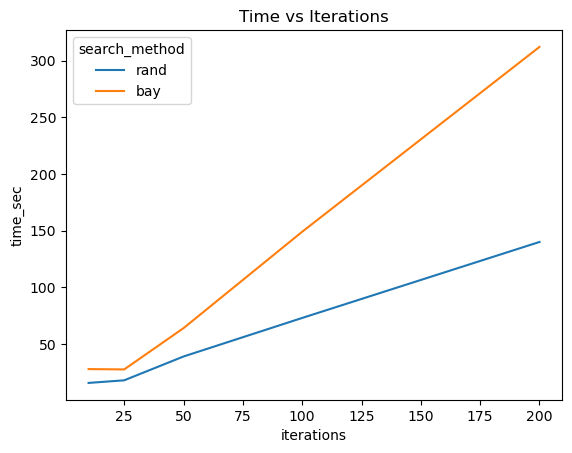

In [66]:
sns.lineplot(data=trial_results, y='time_sec', x='iterations', hue='search_method')
plt.title('Time vs Iterations')

Text(0.5, 1.0, 'RMSE vs Iterations')

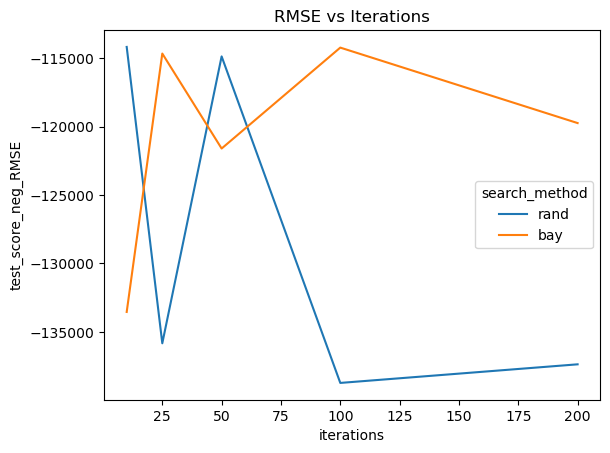

In [68]:
sns.lineplot(data=trial_results, y='test_score_neg_RMSE', x='iterations', hue='search_method')
plt.title('RMSE vs Iterations')